<a href="https://colab.research.google.com/github/PHYRA47/Computer-Vision/blob/main/project2-%20GoogLeNet-on-LFW-deepfunneled-dataset/cv_assignment2_googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

<center><h1></h></center>

<center><h1> GoogLeNet on Labeled Faces Wild (LFW) Dataset </h></center>
<center>Fromsa Teshome Negasa, </center>
<center>Photonics for Security, Reliability, and Safety (PSRS)</center>
<center>Computer Vision Course Assignment</center>
<center>Mohamad KHALIL, Instructor</center>
<center>18<sup>th</sup> November 2024</center>

<center><h1></h></center>

---

# 1 Setup
Checking if the Runtime is on GPU!

In [ ]:
!nvidia-smi

Sun Nov 17 21:08:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0              27W /  70W |   2225MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1.1 Google Drive Authentication and Imports



In [ ]:
# Authenticate and import required libraries
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate the Google account
auth.authenticate_user()  # Prompts user login via Colab

# Initialize PyDrive client
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  # Enables Google Drive operations

## 1.2 Importing Machine Learning and Data Science Modules



In [ ]:
# Import standard libraries for ML, data handling, and visualization
import numpy as np
import pandas as pd
import random
import os
import shutil
from tqdm import tqdm
from glob import glob
import math
from functools import partial

# Scikit-learn utilities and metrics
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Distance computation
from scipy.spatial import distance

# Image handling and visualization
from PIL import Image
from IPython.display import display
from matplotlib.image import pil_to_array, imread
from matplotlib import pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Enable progress bars in pandas operations
tqdm.pandas()

# Set Keras backend to TensorFlow
os.environ["KERAS_BACKEND"] = "tensorflow"

## 1.3 Importing Keras and TensorFlow Modules



In [ ]:
# Import TensorFlow and Keras for deep learning
import tensorflow as tf
import keras

# Keras utilities for image and model operations
from keras.utils import (
    image_dataset_from_directory,
    array_to_img,
    img_to_array,
    load_img,
    plot_model
)
from keras.layers import RandomZoom

# Layers for building neural network architectures
from keras import layers
from keras.models import Model
from keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization, concatenate, Dropout, Flatten, Dense,
    Input, Lambda, AveragePooling2D, Activation, PReLU, ReLU, Add, GlobalAveragePooling2D
)

# Pre-trained models and preprocessing
from keras.applications.resnet_v2 import preprocess_input

# Callbacks for training management
from keras.callbacks import (
    ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau,
    TensorBoard, TerminateOnNaN
)

# Optimizers for gradient descent
from keras.optimizers import SGD, Adam

# TensorFlow/Keras backend for custom operations
import keras.backend as K

# Optimize dataset pipelines
AUTOTUNE = tf.data.AUTOTUNE


## 1.4 Helper Functions for Image Processing and Evaluation

- **Google Drive Helpers**: Upload and download files.
- **Dataset Helpers**: Filter datasets by criteria.
- **Visualization**: Plot histograms, DET curves, and FAR vs. FRR.
- **Performance Metrics**: Compute FAR, FRR, and EER.
- **Template Extraction**: Extract embeddings using a pre-trained model.
- **Path Utility**: Generate image paths dynamically.
- **Evaluation**: Assess model performance using test pairs and report metrics.

### Key Outputs
- EER, FAR/FRR plots, and accuracy score for biometric evaluation.

In [ ]:
# Google Drive Helpers
def drive_upload_file(full_filename):
    """Upload a file to Google Drive."""
    filename = os.path.basename(full_filename)
    file = drive.CreateFile({'title': filename})
    file.SetContentFile(full_filename)
    file.Upload()

def drive_download_file(file_id, local_path='./'):
    """Download a file from Google Drive."""
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.FetchMetadata()
    fn = downloaded.metadata.get('originalFilename')
    full_fn = os.path.join(local_path, fn)
    downloaded.GetContentFile(full_fn)
    return full_fn

# Dataset Helpers
def filter_df(df, min_images_count=0):
    """Filter DataFrame by minimum image count."""
    return df[df.images >= min_images_count].sort_values('images', ascending=False)

# Visualization Helpers
img_root_dir = 'input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
equal_apriori = 0.5 # equal probabilities
num_thresholds = 100

# generate a list of  n thresholds between 0.0 and 1.0
thresholds = [i/num_thresholds for i in range(num_thresholds)]

def plot_scores(imposter, genuine):
    """Plot histograms of genuine and imposter scores."""
    plt.hist(imposter, facecolor='r', alpha=0.5, label='Imposter')
    plt.hist(genuine, facecolor='g', alpha=0.5, label='Genuine')
    plt.xlabel('Score'), plt.ylabel('Frequency')
    plt.title('Score Distribution'), plt.grid(True)
    plt.legend(), plt.show()

def plot_DET_with_EER(far, frr, far_opt, frr_opt):
    """Plot DET curve with EER point."""
    plt.plot(far, frr, linestyle="--", linewidth=4, label="DET Curve")
    plt.plot(far_opt, frr_opt, 'ro', label="EER Point")
    plt.plot([1.0,0.0], [0.0,1.0],"k--") # Draw the default DET Curve from 1-1
    plt.title('Detection Error Tradeoff (DET) curve'), plt.grid(True)
    plt.legend(), plt.show()

def plot_FAR_vs_FRR(far, frr):
    """Plot FAR and FRR against thresholds."""
    plt.plot(thresholds, far, 'g-', label='FAR')
    plt.plot(thresholds, frr, 'b-', label='FRR')
    plt.title('False Acceptance Rate (FAR) vs. False Rejection Rate (FAR)'), plt.grid(True)
    plt.legend(), plt.show()

# Performance Metrics
def calculate_cost(imposter, genuine):
    """Calculate FAR and FRR for thresholds."""
    far, frr = [], []
    for t in thresholds:
        FP = sum(score >= t for score in imposter)
        FN = sum(score < t for score in genuine)
        far.append(FP / len(imposter))
        frr.append(FN / len(genuine))
    return far, frr

def find_EER(far, frr):
    """Find EER (Equal Error Rate) point."""
    delta = np.abs(np.array(far) - np.array(frr))
    idx = np.argmin(delta)
    return far[idx], frr[idx], thresholds[idx]

# Template Extraction
def extract_template(image_paths, model, target_size=(256, 256), batch_size=32):
    """Extract image embeddings using a model."""
    def preprocess_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, target_size)
        return img
    dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_image)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return model.predict(dataset).tolist()

# Path Utility
def name_to_image_path(root_dir, name, image_num):
    """Generate image path."""
    return f'{root_dir}/{name}/{name}_{image_num:04d}.jpg'

def evaluate_model(model, pairs_file='./input/lfw-dataset/course-pairsDevTest.csv'):
    # Cut our model at the 'embedding' layer level and convert it to template extractor
    embedding_out = model.get_layer('face_embedding').output
    template_extrator = Model(inputs=[input_layer], outputs=[embedding_out])

    # Read pairs matched and mismatched for dev dataset
    print('Preparing stats from dev set')
    test_pairs = pd.read_csv(pairs_file)
    test_pairs['img_fn1'] = test_pairs.apply(lambda row: name_to_image_path(img_root_dir, row['name1'], row['imagenum1']), axis=1)
    test_pairs['img_fn2'] = test_pairs.apply(lambda row: name_to_image_path(img_root_dir, row['name2'], row['imagenum2']), axis=1)

    # Apply the template model to all images
    test_pairs['template1'] = extract_template(test_pairs['img_fn1'], template_extrator, target_size)
    test_pairs['template2'] = extract_template(test_pairs['img_fn2'], template_extrator, target_size)
    test_pairs['cos_distance'] = test_pairs.apply(lambda row: distance.cosine(row['template1'], row['template2'])/2., axis=1)  # cos distance rescaled to (0,1)

    match_scores = test_pairs[test_pairs.match_pair==1]['cos_distance']
    mismatch_scores = test_pairs[test_pairs.match_pair==0]['cos_distance']

    # Plot model's stats
    genuine = match_scores.values
    imposter = mismatch_scores.values

    far, frr = calculate_cost(imposter, genuine)
    far_optimum, frr_optimum, err_threshold = find_EER(far, frr)

    plot_scores(imposter, genuine)
    plot_DET_with_EER(far, frr, far_optimum, frr_optimum)
    plot_FAR_vs_FRR(far, frr)
    print(f'EER at threshold: {err_threshold}')

    # Now let's calculate accuracy for test set
    test_pairs['pred_match_pair'] = test_pairs['cos_distance'] < err_threshold
    test_pairs['pred_match_pair'] = test_pairs['pred_match_pair'].astype(int)

    print(f'At threshold {err_threshold} accuracy score is {accuracy_score(test_pairs.match_pair.values, test_pairs.pred_match_pair.values):.4f}')
    return test_pairs

# 2 Dataset preparation

## 2.1 Download and unpack Labelled Faces in the Wild (LFW) files

- **Setup**: Created directories and downloaded dataset from Google Drive.
- **Processing**: Unzipped with `7z` and cleaned temporary files.
- **Output**: Dataset ready at `./input/lfw-dataset/lfw-deepfunneled/`.


In [ ]:
# Prepare Labelled Faces in the Wild dataset
!mkdir -p input/lfw-dataset

# Download LFW file (drive id is '14ra9GYFzdyeubZ5qtSDaDAbFDKPCjdAD')
file_id = '14ra9GYFzdyeubZ5qtSDaDAbFDKPCjdAD'
drive_download_file(file_id, local_path='./input/')

# Unpack zip files
!7z x ./input/lfw-dataset.zip -o./input/lfw-dataset -aoa
!7z x ./input/lfw-dataset/lfw-deepfunneled.zip -o./input/lfw-dataset/lfw-deepfunneled -aoa

# Clean temp files
!rm -r ./input/lfw-dataset/lfw-deepfunneled/__MACOSX/ ./input/lfw-dataset/__MACOSX/



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ./input/                  1 file, 116495068 bytes (112 MiB)

Extracting archive: ./input/lfw-dataset.zip
--
Path = ./input/lfw-dataset.zip
Type = zip
Physical Size = 116495068

  0%     10% 25 - lfw-deepfunneled.zip                               28% 25 - lfw-deepfunneled.zip                               45% 25 - lfw-deepfunneled.zip                               61% 25 - lfw-deepfunneled.zip                               69% 25 - lfw-deepfunneled.zip

In [ ]:
!ls -lh **/**/**

-rw-r--r-- 1 root root 207K Nov 24  2018 input/lfw-dataset/course-pairs.csv
-rw-r--r-- 1 root root  35K Nov 24  2018 input/lfw-dataset/course-pairsDevTest.csv
-rwxr-xr-x 1 root root  99K May 17  2018 input/lfw-dataset/lfw_allnames.csv
-rwxr-xr-x 1 root root 121M May 17  2018 input/lfw-dataset/lfw-deepfunneled.zip
-rwxr-xr-x 1 root root 8.0K May 17  2018 input/lfw-dataset/lfw_readme.txt
-rwxr-xr-x 1 root root 9.7K May 17  2018 input/lfw-dataset/matchpairsDevTest.csv
-rwxr-xr-x 1 root root  22K May 17  2018 input/lfw-dataset/matchpairsDevTrain.csv
-rwxr-xr-x 1 root root  17K May 17  2018 input/lfw-dataset/mismatchpairsDevTest.csv
-rwxr-xr-x 1 root root  37K May 17  2018 input/lfw-dataset/mismatchpairsDevTrain.csv
-rwxr-xr-x 1 root root 161K May 17  2018 input/lfw-dataset/pairs.csv
-rwxr-xr-x 1 root root  99K May 17  2018 input/lfw-dataset/people.csv
-rwxr-xr-x 1 root root  30K May 17  2018 input/lfw-dataset/peopleDevTest.csv
-rwxr-xr-x 1 root root  69K May 17  2018 input/lfw-dataset/peop

## 2.2 Copy Images into Train-Validation Directories

- **Setup**: Loaded LFW labels, filtered individuals with >20 images, and displayed the count.
- **Processing**: Collected images, split into 80% train, 20% validation, created necessary directories, and copied images.
- **Output**: Displayed count of images and a few sample images from the training set.







In [ ]:
# Load LFW labels and keep only people with > min_images_count images
df_train = filter_df(pd.read_csv('./input/lfw-dataset/peopleDevTrain.csv'), min_images_count=20)

# Display first few records and count of filtered entries
df_train.head(), len(df_train)

(               name  images
 1328  George_W_Bush     530
 743    Colin_Powell     236
 3842     Tony_Blair     144
 270    Ariel_Sharon      77
 1543    Hugo_Chavez      71,
 46)

In [ ]:
# Prepare a list of all images for names in train list
all_train = []
for name in df_train.name.values:
    imgs_for_name = glob(f'./input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/{name}/*.jpg')
    all_train += [{'name': name, 'filename': fn} for fn in imgs_for_name]

# Train-validation split (80% train, 20% validation)
df_train = pd.DataFrame(all_train)
df_train, df_val = train_test_split(df_train, train_size=0.8, stratify=df_train.name.values)

In [ ]:
# Check the length of train and validation splits
len(df_train), len(df_val)

(1896, 474)

In [ ]:
# Create directories structure
root_path = 'input/lfw-train-test-split'

weights_path = './weights'
logs_path = f'{root_path}/logs'

# Create necessary directories
os.makedirs(weights_path, exist_ok=True)
os.makedirs(logs_path, exist_ok=True)

train_path = f'{root_path}/train/'
validation_path = f'{root_path}/validation/'

In [ ]:
# Make 'name' directories in the train-valid dirs
shutil.rmtree(train_path, ignore_errors=True)
shutil.rmtree(validation_path, ignore_errors=True)

# Create main directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(validation_path, exist_ok=True)

# Create subdirectories for each name
for name in df_train.name.values:
    os.makedirs(os.path.join(train_path, name), exist_ok=True)
    os.makedirs(os.path.join(validation_path, name), exist_ok=True)

print(f"Created directories: \n{train_path}, \n{validation_path}")

Created directories: 
input/lfw-train-test-split/train/, 
input/lfw-train-test-split/validation/


In [ ]:
# Copy to train dir
for i, row in tqdm(df_train.iterrows()):
    shutil.copy(row['filename'], os.path.join(train_path, row['name']))

# Copy to validation dir
for i, row in tqdm(df_val.iterrows()):
    shutil.copy(row['filename'], os.path.join(validation_path, row['name']))

1896it [00:00, 3659.82it/s]
474it [00:00, 2637.20it/s]


input/lfw-train-test-split/train/George_W_Bush/George_W_Bush_0364.jpg 250 250


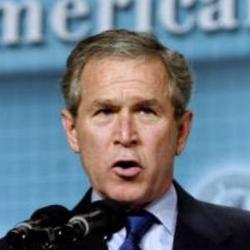

input/lfw-train-test-split/train/Tiger_Woods/Tiger_Woods_0021.jpg 250 250


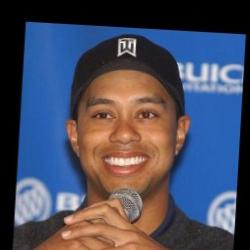

input/lfw-train-test-split/train/Ricardo_Lagos/Ricardo_Lagos_0012.jpg 250 250


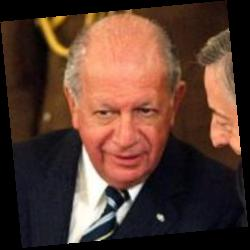

In [ ]:
# Show some images
imgs_fn = glob(f'{train_path}/**/*.jpg', recursive=True)
for fn in np.random.choice(imgs_fn, size=3):
    img = Image.open(fn)
    print(fn, img.height, img.width)
    display(img)

# 3 Train Models

## 3.1 Image Data Generators

In this section, we create data generators for training and validation images with augmentation techniques to improve model generalization.

- **Data Augmentation**: For training, augmentations like random zoom, flip, brightness, contrast, and translation are applied. For validation, minimal augmentation (only resizing) is used.
- **Data Generators**: We use Keras' `image_dataset_from_directory` to load images and create batches. The training data generator includes shuffling, caching, and augmentation, while the validation generator is simpler with resizing.
- **Image Preprocessing**: The preprocessing function applies the defined augmentations to each image before feeding it into the model.

The train and validation generators are checked by visualizing a few images from each.


In [ ]:
# Check the contents of the training directory
!ls {train_path}/*/*.jpg

input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0001.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0002.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0004.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0005.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0006.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0009.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0010.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0011.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0012.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0013.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0014.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0015.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0016.jpg

In [ ]:
# Data generators setup
batch_size = 32 * 3  # Larger batch size for training
target_size = (128, 128)  # Target image size for resizing
n_count = 3  # Number of repetitions for training

In [ ]:
# Training image augmentations
train_img_aug = keras.Sequential([
    keras.layers.RandomZoom((-0.45, -0.55)),  # Random zoom augmentation
    keras.layers.RandomFlip(mode="horizontal"),  # Horizontal flip
    keras.layers.RandomBrightness(0.2),  # Random brightness adjustment
    keras.layers.RandomContrast(0.2),  # Random contrast adjustment
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translation
    keras.layers.Resizing(target_size[0], target_size[1]),  # Resizing images
    # keras.layers.Rescaling(scale=1./255)  # Optional normalization
])

# Validation image augmentation (minimal, only resizing)
valid_img_aug = keras.Sequential([
    keras.layers.RandomZoom((-0.5, -0.5)),  # Zoom for validation set
    keras.layers.Resizing(target_size[0], target_size[1]),  # Resize
    # keras.layers.Rescaling(scale=1./255)  # Optional normalization
])

In [ ]:
# Preprocessing function to apply augmentation
def preprocess(image, label, img_aug):
    image = img_aug(image)  # Apply the augmentation
    return image, label

In [ ]:
# Create training data generator
train_dataset = keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',  # Inferred labels from folder names
    label_mode='categorical',  # One-hot encoded labels
    batch_size=batch_size,
    image_size=(256, 256)  # Resize images to 256x256
)

# Number of classes
n_classes = len(train_dataset.class_names)

# Augment training images
augment_train = partial(preprocess, img_aug=train_img_aug)

# # More real-life version
# train_gen = (train_dataset
#             .cache()
#             .shuffle(100)
#             .map(augment_train, num_parallel_calls=AUTOTUNE)
#             .prefetch(AUTOTUNE)
#             .repeat(n_count)
#             )

# Train generator with augmentation and optimizations
train_gen = (train_dataset
             .map(augment_train, num_parallel_calls=AUTOTUNE)  # Apply augmentation
             .repeat(n_count)  # Repeat dataset n_count times
             .cache()  # Cache images in memory
             .shuffle(100)  # Shuffle dataset
             .prefetch(AUTOTUNE)  # Prefetch for performance
)

# Create validation data generator
valid_dataset = keras.utils.image_dataset_from_directory(
    validation_path,
    labels='inferred',  # Inferred labels
    label_mode='categorical',  # One-hot encoded labels
    batch_size=1,  # Batch size for validation
    image_size=(256, 256)  # Resize images to 256x256
)

# Augment validation images
augment_valid = partial(preprocess, img_aug=valid_img_aug)

# Validation generator with augmentation
valid_gen = (valid_dataset
             .map(augment_valid, num_parallel_calls=AUTOTUNE)  # Apply augmentation
             .prefetch(AUTOTUNE)  # Prefetch for performance
             .cache()  # Cache images
)

Found 1896 files belonging to 46 classes.
Found 474 files belonging to 46 classes.


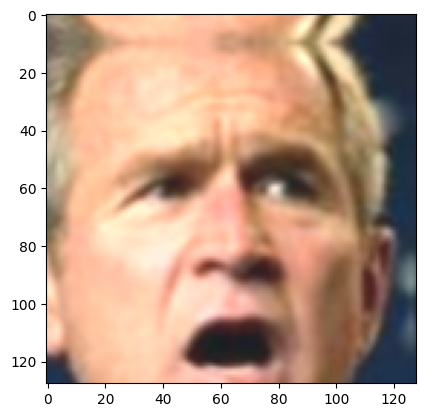

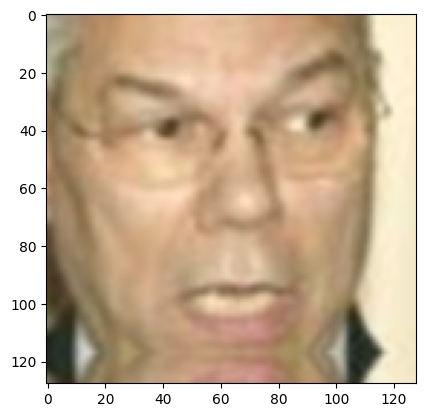

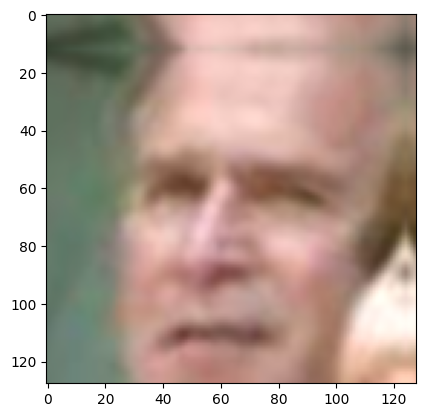

<Figure size 640x480 with 0 Axes>

In [ ]:
# Check if the train data generator works by displaying a few images
batch_x, batch_y = next(iter(train_gen.take(1)))
for x in batch_x.numpy()[:3]:
    plt.imshow(x / 255.)  # Normalize and display images
    plt.figure()

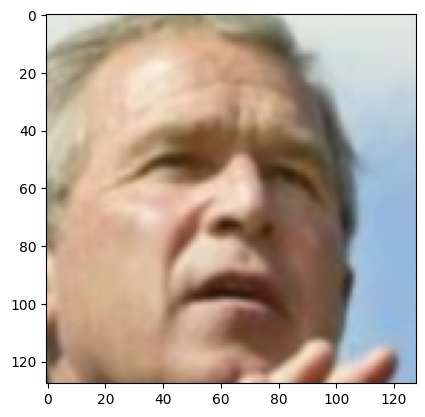

<Figure size 640x480 with 0 Axes>

In [ ]:
# Check the validation data generator by displaying a few images
batch_x, batch_y = next(iter(valid_gen))
for x in batch_x:
    plt.imshow(x / 255.)  # Normalize and display images
    plt.figure()

## 3.2 Common training parameters





In [ ]:
nb_epochs = 5  # Number of epochs for training (iterations over the dataset)
LR = 3e-4  # Learning rate for the optimizer (controls the step size during optimization)

## 3.3 GoogLeNet model

### Overview


**GoogLeNet**, also known as ***Inception-v1***, is a convolutional neural network architecture developed by Google in 2014. It introduced the concept of "Inception modules," which allow the network to choose between multiple convolutional filter sizes within each block. This design helps the network capture various features at different scales, improving its performance and efficiency.


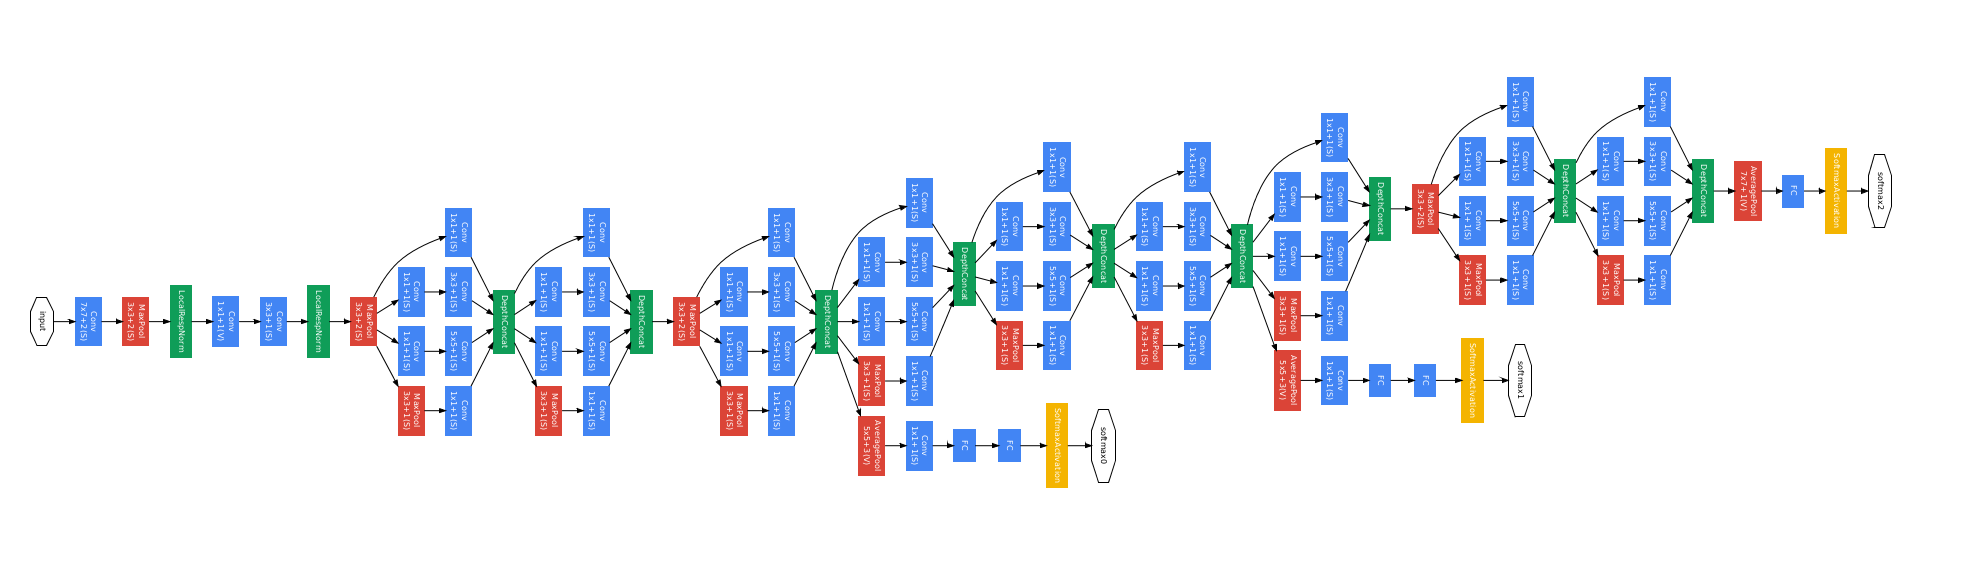



The architecture stacks these Inception modules on top of each other, with occasional max-pooling layers to reduce the spatial dimensions. This approach addresses the issues of vanishing gradients and computational cost that were common in deeper networks.

GoogLeNet achieved significant success in image classification tasks, winning the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2014. Its innovative design has influenced many subsequent neural network architectures.

### Optimizer and Model Checkpoint Setup




In [ ]:
# Optimizer and loss function
optimizer = Adam(learning_rate=LR)  # Adam optimizer with the specified learning rate
cce_loss = keras.losses.CategoricalCrossentropy(from_logits=True)  # Categorical cross-entropy loss function

# Save the best model weights based on validation loss
save_model = ModelCheckpoint(f'{weights_path}/googlenet-weight.weights.h5', monitor='val_loss',
                             save_best_only=True, save_weights_only=True)

### Inception Module



This section defines the inception module, which is a key component of the GoogLeNet architecture. The inception module applies multiple convolutions with different kernel sizes and a max-pooling operation in parallel, followed by concatenation of the results.

- The module consists of:
  - A 1x1 convolution.
  - A 3x3 convolution (after a 1x1 reduction).
  - A 5x5 convolution (after a 1x1 reduction).
  - A max-pooling operation followed by a 1x1 convolution.
- The output is the concatenation of these four branches along the depth axis.


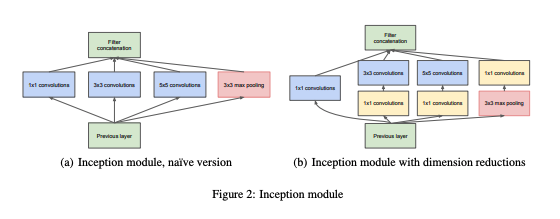

In [ ]:
# Defining the inception module
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 convolution
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # 3x3 convolution with 1x1 reduction
    conv_3x3_reduce = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3_reduce)

    # 5x5 convolution with 1x1 reduction
    conv_5x5_reduce = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5_reduce)

    # Max pooling with 1x1 convolution projection
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Concatenate all branches
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)
    return output

### GoogLeNet Model Definition


In [ ]:
# Create GoogLeNet model
input_shape = target_size + (3,)  # Input shape (height, width, channels)
input_layer = Input(shape=input_shape)  # Input layer
input_layer = layers.Lambda(preprocess_input)(input_layer)  # Preprocess input

x = input_layer

# Initial Convolution and MaxPooling layers
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Multiple Inception modules
x = inception_module(x, 64, 96, 128, 16, 32, 32)
x = inception_module(x, 128, 128, 192, 32, 96, 64)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = inception_module(x, 192, 96, 208, 16, 48, 64)
x = inception_module(x, 160, 112, 224, 24, 64, 64)
x = inception_module(x, 128, 128, 256, 24, 64, 64)
x = inception_module(x, 112, 144, 288, 32, 64, 64)
x = inception_module(x, 256, 160, 320, 32, 128, 128)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = inception_module(x, 256, 160, 320, 32, 128, 128)
x = inception_module(x, 384, 192, 384, 48, 128, 128)

# Final layers
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dropout(0.4)(x)  # Dropout to reduce overfitting
x = Flatten(name="face_embedding")(x)  # Flatten before fully connected layer

# Output layer
output_layer = Dense(n_classes, activation='softmax')(x)  # Softmax output layer for multi-class classification

# Define the model
model = Model(inputs=[input_layer], outputs=[output_layer])

# Compile the model
model.compile(optimizer=optimizer, loss=cce_loss, metrics=['accuracy'])
model.summary()  # Display model summary

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_187CLONE     │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_114 (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ keras_tensor_187CLONE… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 32, 32, 64)     │              0 │ conv2d_114[1][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 32, 32, 64)     │          4,160 │ max_pooling2d_26[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_116 (Conv2D)       │ (None, 32, 32, 192)    │        110,784 │ conv2d_115[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_27          │ (None, 16, 16, 192)    │              0 │ conv2d_116[1][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 16, 16, 96)     │         18,528 │ max_pooling2d_27[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 16, 16, 16)     │          3,088 │ max_pooling2d_27[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 16, 16, 192)    │              0 │ max_pooling2d_27[1][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_117 (Conv2D)       │ (None, 16, 16, 64)     │         12,352 │ max_pooling2d_27[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 16, 16, 128)    │        110,720 │ conv2d_118[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 16, 16, 32)     │         12,832 │ conv2d_120[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_122 (Conv2D)       │ (None, 16, 16, 32)     │          6,176 │ max_pooling2d_28[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18            │ (None, 16, 16, 256)    │              0 │ conv2d_117[1][0],      │
│ (Concatenate)             │                        │                │ conv2d_119[1][0],      │
│                           │                        │                │ conv2d_121[1][0],      │
│                           │                        │                │ conv2d_122[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_124 (Conv2D)       │ (None, 16, 16, 128)    │         32,896 │ concatenate_18[1][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_126 (Conv2D)       │ (None, 16, 16, 32)     │          8,224 │ concatenate_18[1][0]   │
├──────────────────────

 Total params: 6,020,702 (22.97 MB)

 Trainable params: 6,020,702 (22.97 MB)

 Non-trainable params: 0 (0.00 B)

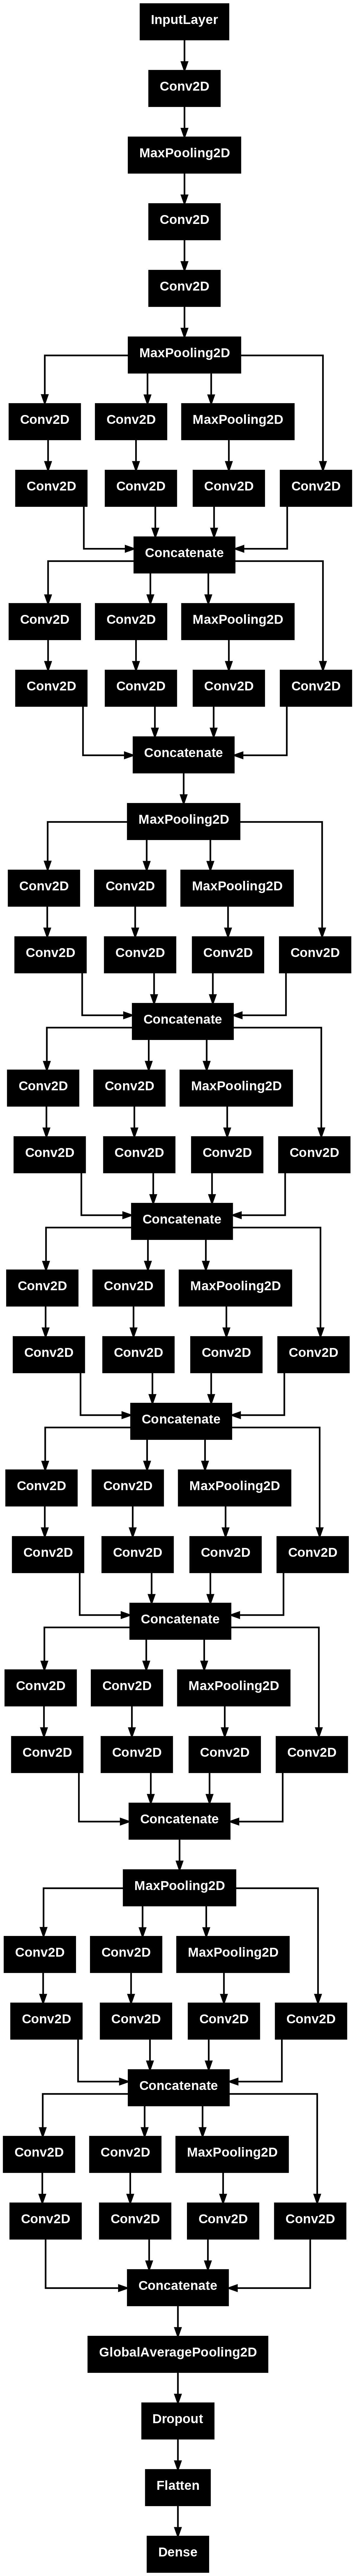

In [ ]:
# Visualize the model structure
plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=False)

### Model Training and Evaluation

Train the model, load the best weights, and evaluate the performance using accuracy, FAR, and FRR scores.


In [ ]:
# Train the model
hist = model.fit(train_gen.repeat(10),
                 epochs=nb_epochs,
                 validation_data=valid_gen,
                 callbacks=[save_model])  # Save best model weights

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


600/600 ━━━━━━━━━━━━━━━━━━━━ 97s 123ms/step - accuracy: 0.2412 - loss: 3.2104 - val_accuracy: 0.6097 - val_loss: 1.3365
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 118s 102ms/step - accuracy: 0.7149 - loss: 0.9447 - val_accuracy: 0.8101 - val_loss: 0.7570
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - accuracy: 0.9559 - loss: 0.1352 - val_accuracy: 0.8502 - val_loss: 0.7694
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 62s 104ms/step - accuracy: 0.9779 - loss: 0.0693 - val_accuracy: 0.8291 - val_loss: 0.7834
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.9804 - loss: 0.0647 - val_accuracy: 0.8418 - val_loss: 0.7989


Plot accuracy and loss valuses over the traning course

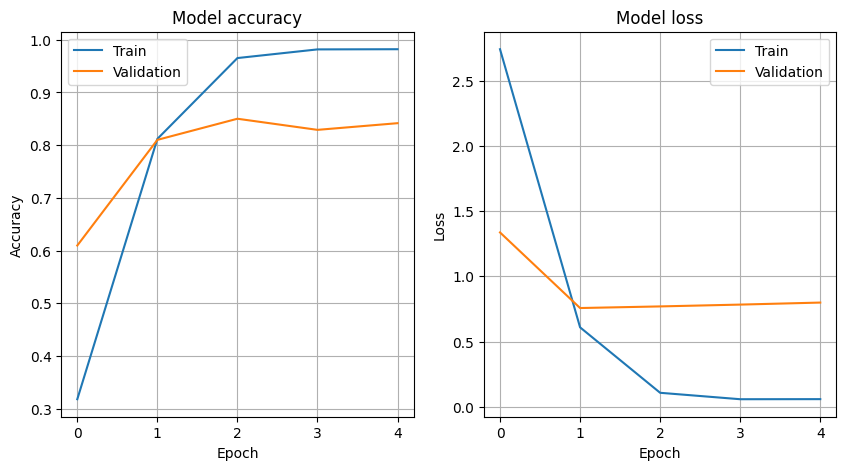

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Load the best model weights after training
model.load_weights(f'{weights_path}/googlenet-weight.weights.h5')

Evaluate the model's performance (Accuracy, FAR, FRR)

Preparing stats from dev set
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


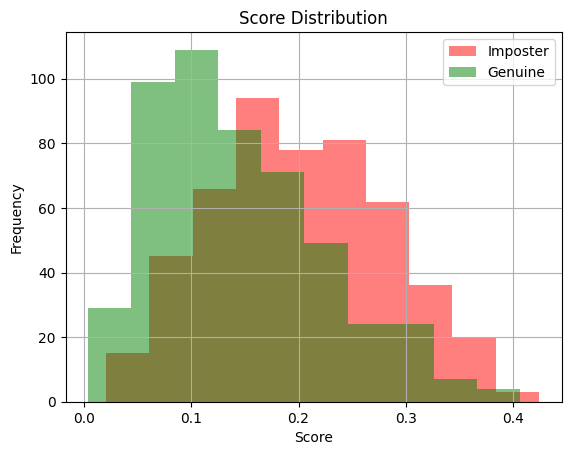

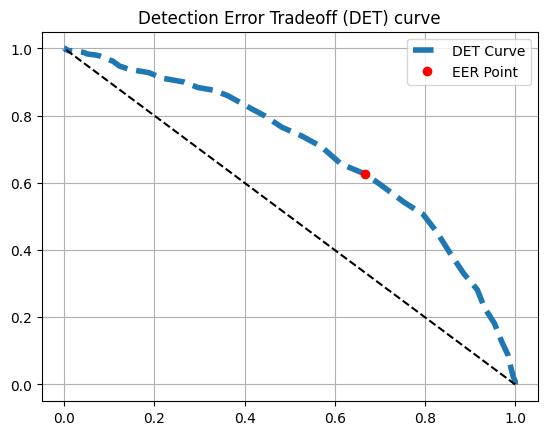

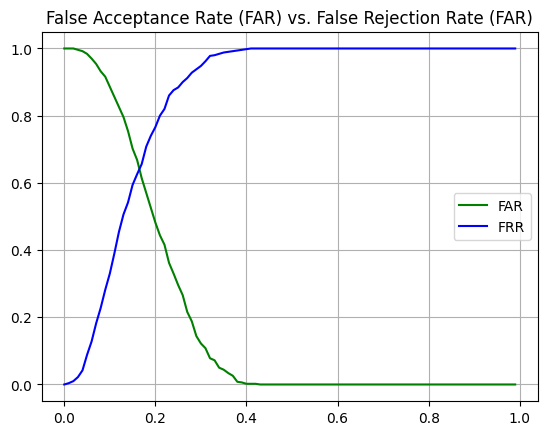

EER at threshold: 0.16
At threshold 0.16 accuracy score is 0.6470


In [ ]:
pairs_df = evaluate_model(model)  # Evaluate model with custom evaluation metrics

# 4 Manual prediction

In [ ]:
from PIL import Image

In [ ]:
fn = "/content/input/lfw-train-test-split/validation/Serena_Williams/Serena_Williams_0009.jpg"
image = Image.open(fn)
image = img_to_array(image)
plt.imshow(image/255.)

In [ ]:
# model_latest = model

In [ ]:
image, _ = augment_valid(image[None],label='Serena_Williams')

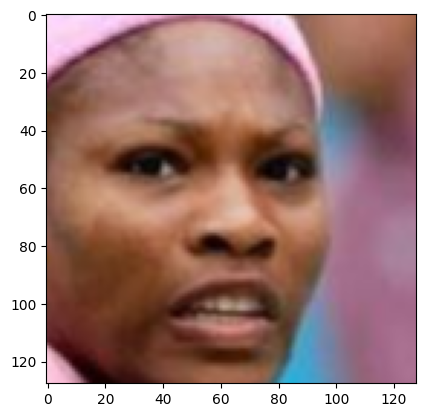

In [ ]:
plt.imshow(image[0]/255.)

In [ ]:
preds = model.predict(image)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
preds

array([7.89877929e-13, 5.75054014e-15, 3.83587384e-09, 5.22879960e-12,
       3.63325681e-09, 1.17646759e-09, 5.04699039e-13, 1.23120336e-15,
       9.29608495e-14, 8.74738134e-07, 5.27683452e-10, 5.47556001e-10,
       1.49907463e-03, 9.69385813e-13, 6.44673269e-17, 6.81430246e-10,
       4.13797954e-11, 3.47766654e-05, 1.90866472e-11, 9.27627007e-13,
       2.18747295e-11, 5.45398926e-12, 9.97096481e-17, 2.73444288e-11,
       1.03729205e-14, 5.13091956e-13, 1.60088853e-09, 1.75813305e-11,
       1.91859441e-13, 8.61409161e-16, 2.92599694e-10, 1.12214819e-16,
       1.26713524e-15, 6.46322391e-08, 1.91279024e-11, 4.79666596e-06,
       1.63450452e-16, 3.11862290e-19, 3.44559976e-06, 5.01790841e-16,
       9.98444378e-01, 1.22828596e-05, 9.72414965e-14, 2.00157043e-13,
       2.19909865e-07, 4.21474577e-10], dtype=float32)

In [ ]:
top = 5
top_indices = preds.argsort()[-top:][::-1]

In [ ]:
top_indices

array([40, 12, 17, 41, 35])

In [ ]:
valid_dataset.class_names

['Alejandro_Toledo',
 'Andre_Agassi',
 'Angelina_Jolie',
 'Ariel_Sharon',
 'Arnold_Schwarzenegger',
 'Atal_Bihari_Vajpayee',
 'Bill_Clinton',
 'Carlos_Menem',
 'Colin_Powell',
 'David_Beckham',
 'George_W_Bush',
 'Gloria_Macapagal_Arroyo',
 'Guillermo_Coria',
 'Hamid_Karzai',
 'Hans_Blix',
 'Hugo_Chavez',
 'Igor_Ivanov',
 'Jack_Straw',
 'Jean_Chretien',
 'Jennifer_Aniston',
 'Jennifer_Lopez',
 'John_Ashcroft',
 'Jose_Maria_Aznar',
 'Juan_Carlos_Ferrero',
 'Junichiro_Koizumi',
 'Laura_Bush',
 'Lindsay_Davenport',
 'Lleyton_Hewitt',
 'Luiz_Inacio_Lula_da_Silva',
 'Megawati_Sukarnoputri',
 'Michael_Bloomberg',
 'Naomi_Watts',
 'Nestor_Kirchner',
 'Paul_Bremer',
 'Pete_Sampras',
 'Recep_Tayyip_Erdogan',
 'Ricardo_Lagos',
 'Roh_Moo-hyun',
 'Rudolph_Giuliani',
 'Saddam_Hussein',
 'Serena_Williams',
 'Tiger_Woods',
 'Tom_Daschle',
 'Tom_Ridge',
 'Tony_Blair',
 'Vladimir_Putin']

In [ ]:
[(valid_dataset.class_names[i], preds[i]) for i in top_indices]

[('Serena_Williams', 0.9984444),
 ('Guillermo_Coria', 0.0014990746),
 ('Jack_Straw', 3.4776665e-05),
 ('Tiger_Woods', 1.228286e-05),
 ('Recep_Tayyip_Erdogan', 4.796666e-06)]